# Record Linkage Example

## Boilerplate

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from importlib import reload
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

In [3]:
import sys

sys.path.insert(0, '..')

In [4]:
import entity_embed  # force n2 import to avoid libgomp issue https://github.com/kakao/n2/issues/42

In [5]:
import torch
import numpy as np

random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

## Load Dataset

We'll use the [Amazon-GoogleProducts](https://dbs.uni-leipzig.de/research/projects/object_matching/benchmark_datasets_for_entity_resolution). The dataset is stored in a ZIP file with 3 CSV files: Two are the entity source files, the third one is the perfect mapping.

Let's download the ZIP:

In [6]:
import urllib
import tempfile

dataset_url = 'https://dbs.uni-leipzig.de/file/Amazon-GoogleProducts.zip'
tf = tempfile.NamedTemporaryFile(mode='r', delete=False)
tf.close()

urllib.request.urlretrieve(dataset_url, tf.name);

Extracting the files:

In [7]:
import zipfile
import os

td = tempfile.TemporaryDirectory()

with zipfile.ZipFile(tf.name, "r") as zf:
    zf.extractall(td.name)

os.listdir(td.name)

['Amazon.csv', 'GoogleProducts.csv', 'Amzon_GoogleProducts_perfectMapping.csv']

Now we must read the **two** CSV files `'Amazon.csv'` and `'GoogleProducts.csv'` into a **single** `dict` called `row_dict`. Therefore, `row_dict` will contain all rows from the dataset, i.e., all rows from both files.

We'll dynamically attribute an ID for each row using `enumerate`. entity-embed needs that too.

Also, to keep track of the IDs of each source file, we must keep a `left_id_set` and a `right_id_set`.

In [8]:
import csv

from entity_embed.data_utils.utils import Enumerator

id_enumerator = Enumerator()
row_dict = {}
left_id_set = set()
right_id_set = set()

with open(f'{td.name}/Amazon.csv', newline='', encoding="latin1") as f:
    for row in csv.DictReader(f):
        row['id'] = id_enumerator[row["id"]]
        row['name'] = row.pop('title')  # in Amazon, name is called title
        row['__source'] = 'amazon'  # for easy debugging, not used by entity-embed
        row_dict[row['id']] = row
        left_id_set.add(row['id'])

with open(f'{td.name}/GoogleProducts.csv', newline='', encoding="latin1") as f:
    for row in csv.DictReader(f):
        row['id'] = id_enumerator[row["id"]]
        row['__source'] = 'google'  # for easy debugging, not used by entity-embed
        row_dict[row['id']] = row
        right_id_set.add(row['id'])

Now we compute the `true_pair_set`:

In [9]:
true_pair_set = set()

with open(f'{td.name}/Amzon_GoogleProducts_perfectMapping.csv', newline='') as f:
    for row in csv.DictReader(f):
        id_left = id_enumerator[row['idAmazon']]
        id_right = id_enumerator[row['idGoogleBase']]
        true_pair_set.add((id_left, id_right))

len(true_pair_set)

1300

Note internally entity-embed will use **clusters, not pairs**.

For this dataset, the number of clusters is smaller than the number of pairs, because some clusters have more than 2 entities. For example, a cluster with 3 entities means 2 entities from a file link to 1 row from the other file. This is not a problem for entity-embed. In fact, it's important for entity-embed to know the full clusters in order to learn better embeddings. See an example here:

In [10]:
from entity_embed.data_utils.utils import id_pairs_to_cluster_mapping_and_dict

cluster_mapping, cluster_dict = id_pairs_to_cluster_mapping_and_dict(true_pair_set)
len(cluster_dict)

1105

In [11]:
cluster_dict[262]

[262, 2485, 2488]

In [12]:
for id_ in cluster_dict[262]:
    display(row_dict[id_])

{'id': 262,
 'description': 'sp linux we 50 lic/cd 3.0c',
 'manufacturer': 'hewlett packard (consumables)',
 'price': '0',
 'name': 'hp sp linux we 50 lic/cd 3.0c ( t3586a )',
 '__source': 'amazon'}

{'id': 2485,
 'name': 'sp linux we 50 lic/cd 3.0c',
 'description': '',
 'manufacturer': '',
 'price': '69216.95',
 '__source': 'google'}

{'id': 2488,
 'name': 'sp linux we 50 lic/cd 3.0c',
 'description': '',
 'manufacturer': '',
 'price': '69216.95',
 '__source': 'google'}

Note that there are additional pairs in clusters when compared to `true_pair_set`. That's because it's useful for entity-embed to also learn that cases like `(2485, 2488)` represent the same entity, even though they belong to the same dataset and won't be returned in the final pairwise results.

In [13]:
from entity_embed.data_utils.utils import cluster_dict_to_id_pairs

len(cluster_dict_to_id_pairs(cluster_dict) - true_pair_set)

253

Clean up the temporary files:

In [14]:
import os

td.cleanup()
os.remove(tf.name)

## Preprocess

We'll perform a very minimal preprocessing of the dataset. We want to simply force ASCII chars, lowercase all chars, strip leading and trailing whitespace, and limit any value to 500 tokens and 5000 chars to avoid memory errors.

The fields we'll clean are the ones we'll use:

In [15]:
attr_list = ['name', 'description', 'manufacturer', 'price']

In [16]:
import unidecode
import itertools
from entity_embed import default_tokenizer

def clean_str(s):
    max_tokens = 100
    max_chars = 1000
    s = unidecode.unidecode(s).lower().strip()
    s_tokens = default_tokenizer(s)[:max_tokens]
    return ' '.join(s_tokens)[:max_chars]

for row in row_dict.values():
    for attr in attr_list:
        row[attr] = clean_str(row[attr])

Forcing ASCII chars in this dataset is useful to improve recall because there's little difference between accented and not-accented chars here. Also, this dataset contains mostly latin chars.

It's worth noting you can use any alphabet you need, so this accent removal is optional.

## Configure entity-embed attributes

Now we will define how row fields (entity attributes) will be numericalized and encoded by the neural network. First we set an `alphabet`, here we'll use ASCII numbers, letters, symbols and space:

In [17]:
alphabet = list('0123456789abcdefghijklmnopqrstuvwxyz!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ ')

Then we set an `attr_info_dict`. It defines types, which determine how attributes are processed in the neural network:

In [18]:
attr_info_dict = {
    'name': {
        'field_type': "MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
        'use_mask': True,
    },
    'semantic_name': {
        'source_attr': 'name',
        'field_type': "SEMANTIC_MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'vocab': "fasttext.en.300d",
        'use_mask': True,
    },
    'description': {
        'field_type': "MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
        'use_mask': True,
    },
    'semantic_description': {
        'source_attr': 'description',
        'field_type': "SEMANTIC_MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'vocab': "fasttext.en.300d",
        'use_mask': True,
    },
    'manufacturer': {
        'field_type': "MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
        'use_mask': True,
    },
    'price': {
        'field_type': "STRING",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
        'use_mask': True,
    }
}

Then we use our `attr_info_dict` to get a `row_numericalizer`.

The same `row_numericalizer` must be used on ALL data: train, valid, test. This ensures numericalization will be consistent. Also, one must keep this `row_numericalizer` to use on production data:

In [19]:
from entity_embed import AttrInfoDictParser

row_numericalizer = AttrInfoDictParser.from_dict(attr_info_dict, row_dict=row_dict)
row_numericalizer.attr_info_dict

14:50:54 INFO:For attr=name, computing actual max_str_len
14:50:54 INFO:For attr=name, using actual_max_str_len=26
14:50:54 INFO:Loading vectors from .vector_cache/wiki.en.vec.pt
14:50:58 INFO:For attr=description, computing actual max_str_len
14:50:58 INFO:actual_max_str_len=29 must be pair to enable NN pooling. Updating to 30
14:50:58 INFO:For attr=description, using actual_max_str_len=30
14:50:58 INFO:Loading vectors from .vector_cache/wiki.en.vec.pt
14:51:01 INFO:For attr=manufacturer, computing actual max_str_len
14:51:01 INFO:actual_max_str_len=15 must be pair to enable NN pooling. Updating to 16
14:51:01 INFO:For attr=manufacturer, using actual_max_str_len=16
14:51:01 INFO:For attr=price, computing actual max_str_len
14:51:01 INFO:For attr=price, using actual_max_str_len=14


{'name': NumericalizeInfo(source_attr='name', field_type=<FieldType.MULTITOKEN: 'multitoken'>, tokenizer='entity_embed.data_utils.numericalizer.default_tokenizer', alphabet=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', ' '], max_str_len=26, vocab=None, n_channels=8, embed_dropout_p=0.2, use_attention=True, use_mask=True),
 'semantic_name': NumericalizeInfo(source_attr='name', field_type=<FieldType.SEMANTIC_MULTITOKEN: 'semantic_multitoken'>, tokenizer='entity_embed.data_utils.numericalizer.default_tokenizer', alphabet=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',

## Initialize Data Module

Under the hoods entity-embed uses [pytorch-lightning](https://www.pytorchlightning.ai/), so we need to create a datamodule object to split our dataset between train, valid, and test data.

In [20]:
clusters_total = len(cluster_dict)
clusters_total

1105

Since there's a lot of clusters, we'll use only 200 for training, and other 200 for validation. We want to simulate a real dataset behavior. It's difficult to have a lot of training data for record linkage.

In [21]:
from entity_embed import LinkageDataModule

train_cluster_len = 200
valid_cluster_len = 200
batch_size = 20
row_batch_size = 50
datamodule = LinkageDataModule(
    row_dict=row_dict,
    left_id_set=left_id_set,
    right_id_set=right_id_set,
    row_numericalizer=row_numericalizer,
    batch_size=batch_size,
    row_batch_size=row_batch_size,
    true_pair_set=true_pair_set,
    train_cluster_len=train_cluster_len,
    valid_cluster_len=valid_cluster_len,
    test_cluster_len=clusters_total - valid_cluster_len - train_cluster_len,
    only_plural_clusters=True,
    random_seed=random_seed
)

We've used `LinkageDataModule` because we're doing Record Linkage of a multiple datasets/tables.

We're NOT doing Deduplication of a single dataset here. Check the other notebook Deduplication if you want to learn how to do it with entity-embed.

## Training

Now the training process! Thanks to pytorch-lightining, it's easy to train, validate, and test with the same datamodule.

We must choose the approximate nearest neighbors K, i.e., the top N our model will use to find duplicates in the embedding space. Below we're setting it on `ann_k` and initializing the `EntityEmbed` model object:

In [22]:
from entity_embed import LinkageEmbed

ann_k = 100
model = LinkageEmbed(
    datamodule,
    ann_k=ann_k,
)

Inspecting the model will reveal it's built based on the attributes we set on `attr_info_dict`: 

In [23]:
model

LinkageEmbed(
  (blocker_net): BlockerNet(
    (embedding_net_dict): ModuleDict(
      (name): MultitokenAttentionEmbed(
        (embedding_net): StringEmbedCNN(
          (conv1): Conv1d(1, 8, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (dense_net): Sequential(
            (0): Linear(in_features=7176, out_features=300, bias=True)
            (1): Dropout(p=0.2, inplace=False)
          )
        )
        (gru): GRU(300, 150, batch_first=True, bidirectional=True)
        (attention_net): MaskedAttention()
      )
      (semantic_name): MultitokenAttentionEmbed(
        (embedding_net): SemanticEmbedNet(
          (dense_net): Sequential(
            (0): Embedding(5565, 300)
            (1): Dropout(p=0.2, inplace=False)
          )
        )
        (gru): GRU(300, 150, batch_first=True, bidirectional=True)
        (attention_net): MaskedAttention()
      )
      (description): MultitokenAttentionEmbed(
        (embedding_net): StringEmbedCNN(
          (conv1

To train, we use a [pytorch-lightning Trainer](https://pytorch-lightning.readthedocs.io/en/1.1.6/trainer.html).

As Entity Embed focus is on recall, we'll define an `EarlyStopping` by `valid_recall_at_0.3`.

`0.3` here is the threshold for cosine similarity of embedding vectors. Note we're using a validation metric, as the training process will run validation on every epoch due to `check_val_every_n_epoch=1`.

We also set a `TensorBoardLogger`, thus you can use `tensorboard --logdir notebooks/tb_logs` to check the train and valid metrics.

In [24]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

max_epochs = 100
early_stop_callback = EarlyStopping(
   monitor='valid_recall_at_0.3',
   min_delta=0.00,
   patience=20,
   verbose=True,
   mode='max'
)
tb_log_dir = 'tb_logs'
tb_name = 'amazon-google'
trainer = pl.Trainer(
    gpus=1,
    max_epochs=max_epochs,
    check_val_every_n_epoch=1,
    callbacks=[early_stop_callback],
    logger=TensorBoardLogger(tb_log_dir, name=tb_name)
)

14:51:01 INFO:GPU available: True, used: True
14:51:01 INFO:TPU available: None, using: 0 TPU cores
14:51:01 INFO:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


OK, all set, call `fit`!

In [25]:
trainer.fit(model, datamodule)

14:51:01 INFO:Train pair count: 290
14:51:01 INFO:Valid pair count: 228
14:51:01 INFO:Test pair count: 834
14:51:03 INFO:
  | Name        | Type       | Params
-------------------------------------------
0 | blocker_net | BlockerNet | 14.7 M
1 | losser      | SupConLoss | 0     
-------------------------------------------
9.2 M     Trainable params
5.6 M     Non-trainable params
14.7 M    Total params


1

Now training is done, we can easily check which attributes are most important for the final embedding:

In [26]:
model.blocker_net.get_signature_weights()

{'name': 0.21048662066459656,
 'semantic_name': 0.19877301156520844,
 'description': 0.16598652303218842,
 'semantic_description': 0.1692516803741455,
 'manufacturer': 0.1284189075231552,
 'price': 0.12708322703838348}

And we can check the best validation model:

In [27]:
from entity_embed import validate_best

validate_best(trainer)

{'valid_f1_at_0.3': 0.36820762368207627,
 'valid_f1_at_0.5': 0.7787934186471663,
 'valid_f1_at_0.7': 0.8105515587529977,
 'valid_f1_at_0.9': 0.24427480916030533,
 'valid_pair_entity_ratio_at_0.3': 2.3481308411214954,
 'valid_pair_entity_ratio_at_0.5': 0.7453271028037384,
 'valid_pair_entity_ratio_at_0.7': 0.441588785046729,
 'valid_pair_entity_ratio_at_0.9': 0.0794392523364486,
 'valid_precision_at_0.3': 0.22587064676616916,
 'valid_precision_at_0.5': 0.6677115987460815,
 'valid_precision_at_0.7': 0.8941798941798942,
 'valid_precision_at_0.9': 0.9411764705882353,
 'valid_recall_at_0.3': 0.9956140350877193,
 'valid_recall_at_0.5': 0.9342105263157895,
 'valid_recall_at_0.7': 0.7412280701754386,
 'valid_recall_at_0.9': 0.14035087719298245}

## Testing

With the best validation model (`ckpt_path='best'`), we can check the performance on the test set: 

In [28]:
trainer.test(ckpt_path='best', verbose=False)

14:52:39 INFO:Train pair count: 290
14:52:39 INFO:Valid pair count: 228
14:52:39 INFO:Test pair count: 834


[{'test_f1_at_0.3': 0.13699307616221562,
  'test_f1_at_0.5': 0.4624310995068175,
  'test_f1_at_0.7': 0.6622381195707715,
  'test_f1_at_0.9': 0.2887804878048781,
  'test_pair_entity_ratio_at_0.3': 7.345903771131339,
  'test_pair_entity_ratio_at_0.5': 1.698959687906372,
  'test_pair_entity_ratio_at_0.7': 0.7301690507152145,
  'test_pair_entity_ratio_at_0.9': 0.12418725617685306,
  'test_precision_at_0.3': 0.07355284121083377,
  'test_precision_at_0.5': 0.30501339456563337,
  'test_precision_at_0.7': 0.5770258236865539,
  'test_precision_at_0.9': 0.774869109947644,
  'test_recall_at_0.3': 0.9964028776978417,
  'test_recall_at_0.5': 0.9556354916067147,
  'test_recall_at_0.7': 0.7769784172661871,
  'test_recall_at_0.9': 0.1774580335731415}]

## Testing manually (like a production run)

When running in production, you only have access to the trained `model` object and the production `row_dict`:

In [29]:
test_row_dict = datamodule.test_row_dict
test_left_id_set = set(id_ for id_ in left_id_set if id_ in test_row_dict)
test_right_id_set = set(id_ for id_ in right_id_set if id_ in test_row_dict)

Keep the `test_true_pair_set` in a variable for evaluation:

In [30]:
test_true_pair_set = datamodule.test_true_pair_set

Before testing manually, do some cleanup:

In [31]:
import gc
del trainer
del datamodule
gc.collect()
torch.cuda.empty_cache()

Then call `predict`:

In [32]:
test_left_vector_dict, test_right_vector_dict = model.predict(
    row_dict=test_row_dict,
    left_id_set=test_left_id_set,
    right_id_set=test_right_id_set,
    batch_size=row_batch_size
)

Double-check if returned embeddings on `test_left_vector_dict` and `test_right_vector_dict` have the same length of `test_row_dict`:

In [33]:
assert (len(test_left_vector_dict) + len(test_right_vector_dict)) == len(test_row_dict)

Now init an `ANNLinkageIndex`, insert all embeddings from both `test_left_vector_dict` and `test_right_vector_dict` on it, and build it:

In [34]:
%%time

from entity_embed import ANNLinkageIndex

ann_index = ANNLinkageIndex(embedding_size=model.embedding_size)
ann_index.insert_vector_dict(left_vector_dict=test_left_vector_dict, right_vector_dict=test_right_vector_dict)
ann_index.build()

CPU times: user 430 ms, sys: 4.38 ms, total: 435 ms
Wall time: 84.1 ms


With the index built, we can now search on it and find the candidate duplicate pairs:

In [35]:
%%time

sim_threshold = 0.3
found_pair_set = ann_index.search_pairs(
    k=ann_k,
    sim_threshold=sim_threshold,
    left_vector_dict=test_left_vector_dict,
    right_vector_dict=test_right_vector_dict,
)

CPU times: user 662 ms, sys: 3.36 ms, total: 666 ms
Wall time: 106 ms


Let's check now the metrics of the found duplicate pairs:

In [36]:
from entity_embed.evaluation import pair_entity_ratio

pair_entity_ratio(len(found_pair_set), len(test_row_dict))

7.345903771131339

In [37]:
from entity_embed.evaluation import precision_and_recall

precision_and_recall(found_pair_set, test_true_pair_set)

(0.07355284121083377, 0.9964028776978417)

Same numbers of the `trainer.test`, so our manual testing is fine.

Finally, we can check the false positives and negatives to see if they're really difficult:

In [38]:
false_positives = list(found_pair_set - test_true_pair_set)
len(false_positives)

10467

In [39]:
false_negatives = list(test_true_pair_set - found_pair_set)
len(false_negatives)

3

In [40]:
cos_similarity = lambda a, b: np.dot(a, b)

In [47]:
for (id_left, id_right) in false_positives[:3]:
    display(
        (
            cos_similarity(test_left_vector_dict[id_left], test_right_vector_dict[id_right]),
            row_dict[id_left], row_dict[id_right]
        )
    )

(0.3046131,
 {'id': 185,
  'description': 'iremember digital scrapbook makes it easier than ever to create gorgeous scrapbooks on your mac ! finish a page in only minutes - just add a blank page to your scrapbook using iremember drag in a template add your photos resize crop and share add text to your creations - familiar poems quotations scripture verses and more',
  'manufacturer': 'intriguing development',
  'price': '39 . 95',
  'name': 'iremember digital scrapbooking 2 . 0',
  '__source': 'amazon'},
 {'id': 3312,
  'name': 'nova development ghw humorous greeting card factory',
  'description': 'art explosion humorous greeting card factory is the most powerful yet easy to use humorous greeting card software available . it goes far beyond competing products with many more unique possibilities now you can personalize and send the best ...',
  'manufacturer': 'nova development',
  'price': '29 . 99',
  '__source': 'google'})

(0.30616975,
 {'id': 630,
  'description': "stopzilla 4 offers real - time protection from spyware and adware . it ' s got the most advanced pop - up protection available and it also has integrated cookie cleaning and history removal . keep your pc security updated constantly with configurable alert warnings and automatic updates . make sure you always intercept unwanted intrusions and annoying online advertising . free 24 / 7 support via live chat email or toll free 800 number",
  'manufacturer': 'roxio',
  'price': '47 . 33',
  'name': 'stopzilla 4 . 0',
  '__source': 'amazon'},
 {'id': 3699,
  'name': 'webroot software 54210 desktop firewall',
  'description': 'protecting your computer from unauthorized access has never been easier two - way firewall protection keeps your data in and intruders out desktop firewall secures your computer from internet threats . a computer without a firewall is easy prey for ...',
  'manufacturer': 'webroot software',
  'price': '26 . 99',
  '__source'

(0.32075423,
 {'id': 974,
  'description': 'vegas movie studio + dvd platinum software offers everything you get with the standard version such as easy drag - and - drop video editing integrated dvd layout and burning and show me how interactive tutorials . in addition platinum edition provides added features advanced editing tools bonus video effects and comprehensive training to speed you through even the most complex movie projects -- from fullscreen dv to widescreen hdv . video editing and dvd creation software vegas movie studio platinum edition software provides the power features and advanced tools you need to edit video in nearly any format including',
  'manufacturer': 'sony media',
  'price': '129 . 95',
  'name': 'sony vegas movie studio + dvd 8 platinum edition',
  '__source': 'amazon'},
 {'id': 3472,
  'name': 'motu digital performer dp5 software music production software',
  'description': 'digital performer 5 ( dp5 ) multi - track audio / midi recorder / editor software 

In [41]:
for (id_left, id_right) in false_negatives[:3]:
    display(
        (
            cos_similarity(test_left_vector_dict[id_left], test_right_vector_dict[id_right]),
            row_dict[id_left], row_dict[id_right]
        )
    )

(0.2551597,
 {'id': 918,
  'description': 'mobi 70008 recam 4 . 6 camera monitoring and notification software surveillance software captures and analyzes images for advanced monitoring and recording of home or office ; program performs simultaneous recording and broadcasting from unlimited number of cameras from any video device ; monitor homes or business from any location with internet access ; notification and viewing via e - mail internet or pda phones ; keep archived videos or images on hard drives or network hard drives ; view and record from multiple cameras simultaneously ; multi - brand and model compatibility allows for efficient and flexible system setup',
  'manufacturer': 'mobi technologies inc .',
  'price': '129',
  'name': 'recam remote monitoring software',
  '__source': 'amazon'},
 {'id': 3921,
  'name': 'mobi - cam 70008 monitoring and notification software',
  'description': 'easily set - up and monitor your home or business observation system from anywhere notifica

(-0.08219031,
 {'id': 845,
  'description': "iplaymusic ' s beginner guitar lessons is the first guitar learning program optimized for the mac and video ipod . the software takes advantage of ilife applications resident on today ' s mac including garageband itunes and iweb . now aspiring musicians have everything they need to learn guitar play and sing popular songs and easily create their own performances . users can view lessons or listen to their new performances in itunes or on their ipod",
  'manufacturer': 'iplaymusic',
  'price': '49 . 99',
  'name': 'iplaymusic beginner guitar lessons for the mac and ipod',
  '__source': 'amazon'},
 {'id': 2324,
  'name': "wingnuts 2 : raina ' s revenge",
  'description': 'system requirements : mac os x 10 . 4 + g4 / g5 / intel 800 + mhz cpu 512 mb ram 32 mb video card 950 mb hard drive space',
  'manufacturer': '',
  'price': '28 . 99',
  '__source': 'google'})

(0.26657262,
 {'id': 1124,
  'description': 'printmusic ! is simply the best entry level notation software . consider it a word processor for printing music notes instead of text . designed for the less demanding user printmusic ! is easy to use and fun to learn . it was developed for the budding composer and works with both midi and acoustic instruments . no other notation software provides output of such exceptional quality for such a low price . you can do everything you need to create play back and print publisher - quality sheet music up to 24 staves . special set - up wizard',
  'manufacturer': 'makemusic !',
  'price': '69 . 99',
  'name': 'emedia print music 2006 win / mac',
  '__source': 'amazon'},
 {'id': 3546,
  'name': 'make printmusic 2006 software music production software',
  'description': "printmusic 2006 - sheet music creation software - mac os x and windows designed for educators worship directors performing musicians composers and arrangers who don ' t require the a

## t-sne visualization

Let's visualize a small sample of the test embeddings and see if they look properly clustered:

In [42]:
vis_sample_size = 10

In [43]:
from entity_embed.data_utils.utils import row_dict_to_cluster_dict

test_vector_dict = {**test_left_vector_dict, **test_right_vector_dict}
__, test_cluster_dict = id_pairs_to_cluster_mapping_and_dict(test_true_pair_set)
vis_cluster_dict = dict(sorted(test_cluster_dict.items(), key=lambda x: len(x[1]), reverse=True)[:vis_sample_size])

In [44]:
vis_x = np.stack([test_vector_dict[id_] for cluster in vis_cluster_dict.values() for id_ in cluster])
vis_y = np.array([cluster_id for cluster_id, cluster in vis_cluster_dict.items() for __ in cluster])

In [45]:
from sklearn.manifold import TSNE

tnse = TSNE(metric='cosine', perplexity=10, random_state=random_seed)
tsne_results = tnse.fit_transform(vis_x)

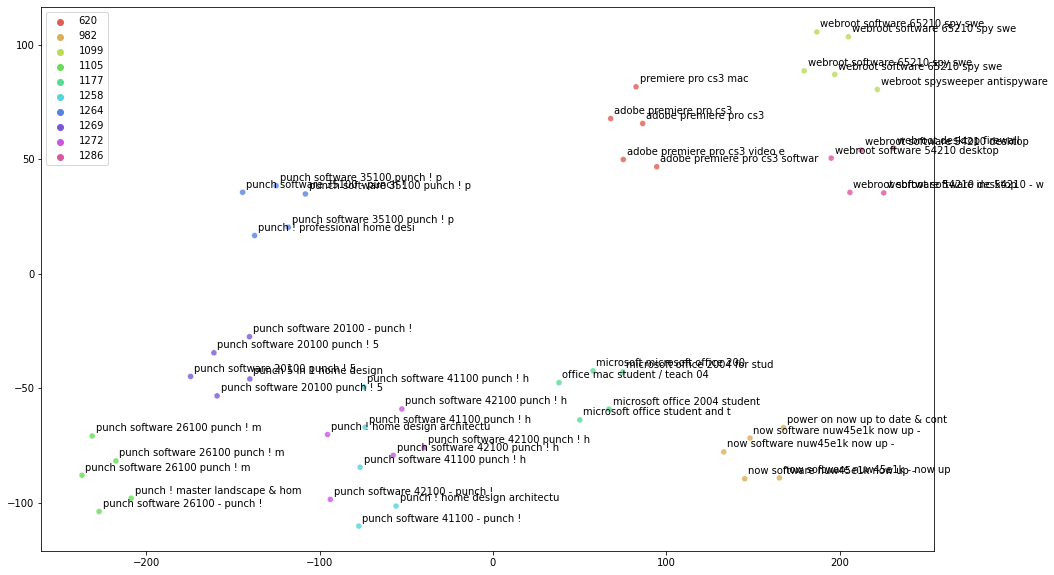

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x=tsne_results[:,0],
    y=tsne_results[:,1],
    hue=vis_y,
    palette=sns.color_palette("hls", len(vis_cluster_dict.keys())),
    legend="full",
    alpha=0.8
)
for id_, (x, y) in zip(itertools.chain.from_iterable(vis_cluster_dict.values()), tsne_results):
    # text = id_
    text = test_row_dict[id_]['name'][:30]
    ax.text(x + 2, y + 2, text)